In [1]:
# A notebook to implement subpopulation attacks on the UCI Adult dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import neural_network, linear_model, cluster
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import seaborn as sns

## Import Data

In [3]:
# Import UCI Adult datasets as pandas dataframes

uci_train_data = pd.read_csv('data/adult/adult.data', header=None, names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'captial-gain',
    'capital-loss', 'hours-per-week', 'native-country', 'income'])

print(f'Training shape: {uci_train_data.shape}')

uci_test_data = pd.read_csv('data/adult/adult.test', header=None, names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'captial-gain',
    'capital-loss', 'hours-per-week', 'native-country', 'income'])

print(f'Test shape: {uci_test_data.shape}')

uci_data = pd.concat([uci_train_data, uci_test_data], axis=0)
print(f'UCI dataset shape: {uci_data.shape}')
uci_data.head()

# Initially 15 columns

Training shape: (32561, 15)
Test shape: (16282, 15)
UCI dataset shape: (48843, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


## Preprocess Data

In [4]:
# Paper drops the following columns, due to siginificant correlation with other columns:
# education
# native-country
# fnlwgt

uci_data = uci_data.drop(columns=['education', 'native-country', 'fnlwgt'], axis=1)
print(f'UCI dataset shape after dropping columns: {uci_data.shape}')

# Paper then one-hot encodes all columns that are categorical values (plus education-num):
# workclass
# education
# marital-status
# occupation
# relationship
# race

categorical_columns = ['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'income']

for column in categorical_columns:
    if '-' in column:
        column_prefix = column.split('-')[0]
    else:
        column_prefix = column

    uci_data = pd.concat([uci_data, pd.get_dummies(uci_data[column], prefix=column_prefix, drop_first=True)], axis=1)
    uci_data = uci_data.drop(column, axis=1)

print(f'UCI dataset shape after one-hot encoding: {uci_data.shape}')
print(list(uci_data.columns))
uci_data.head()

UCI dataset shape after dropping columns: (48843, 12)
UCI dataset shape after one-hot encoding: (48843, 60)
['age', 'captial-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Never-worked', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_2.0', 'education_3.0', 'education_4.0', 'education_5.0', 'education_6.0', 'education_7.0', 'education_8.0', 'education_9.0', 'education_10.0', 'education_11.0', 'education_12.0', 'education_13.0', 'education_14.0', 'education_15.0', 'education_16.0', 'marital_ Married-AF-spouse', 'marital_ Married-civ-spouse', 'marital_ Married-spouse-absent', 'marital_ Never-married', 'marital_ Separated', 'marital_ Widowed', 'occupation_ Adm-clerical', 'occupation_ Armed-Forces', 'occupation_ Craft-repair', 'occupation_ Exec-managerial', 'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners', 'occupation_ Machine-op

,age,captial-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,relationship_ Unmarried,relationship_ Wife,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Male,income_ <=50K.,income_ >50K,income_ >50K.
0,39,2174.0,0.0,40.0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1,50,0.0,0.0,13.0,0,0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
2,38,0.0,0.0,40.0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
3,53,0.0,0.0,40.0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
4,28,0.0,0.0,40.0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0


In [5]:
# Find any columns will null/NaN values
uci_data.isnull().sum() 

age                               0
captial-gain                      1
capital-loss                      1
hours-per-week                    1
workclass_ Federal-gov            0
workclass_ Local-gov              0
workclass_ Never-worked           0
workclass_ Private                0
workclass_ Self-emp-inc           0
workclass_ Self-emp-not-inc       0
workclass_ State-gov              0
workclass_ Without-pay            0
education_2.0                     0
education_3.0                     0
education_4.0                     0
education_5.0                     0
education_6.0                     0
education_7.0                     0
education_8.0                     0
education_9.0                     0
education_10.0                    0
education_11.0                    0
education_12.0                    0
education_13.0                    0
education_14.0                    0
education_15.0                    0
education_16.0                    0
marital_ Married-AF-spouse  

In [6]:
# Drop any rows containing NaN values
print(f'UCI dataset before dropping rows containing NAN values: {uci_data.shape}')
uci_data = uci_data.dropna(0)
print(f'UCI dataset after dropping rows containing NAN values: {uci_data.shape}')

UCI dataset before dropping rows containing NAN values: (48843, 60)
UCI dataset after dropping rows containing NAN values: (48842, 60)


/var/folders/z9/cm7sm3g127n68j1yhvddfqjc0000gn/T/ipykernel_29148/2205887389.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  uci_data = uci_data.dropna(0)


In [7]:
# Double check that all null/NaN values have been removed
uci_data.isnull().sum()

age                               0
captial-gain                      0
capital-loss                      0
hours-per-week                    0
workclass_ Federal-gov            0
workclass_ Local-gov              0
workclass_ Never-worked           0
workclass_ Private                0
workclass_ Self-emp-inc           0
workclass_ Self-emp-not-inc       0
workclass_ State-gov              0
workclass_ Without-pay            0
education_2.0                     0
education_3.0                     0
education_4.0                     0
education_5.0                     0
education_6.0                     0
education_7.0                     0
education_8.0                     0
education_9.0                     0
education_10.0                    0
education_11.0                    0
education_12.0                    0
education_13.0                    0
education_14.0                    0
education_15.0                    0
education_16.0                    0
marital_ Married-AF-spouse  

In [8]:
# Combine the two "income_ >50K" columns into one
print(f'UCI dataset before grouping income columns: {uci_data.shape}')
uci_data['income_ >50K.'] = uci_data.pop('income_ >50K.') + uci_data.pop('income_ >50K')
print(f'UCI dataset after grouping income columns: {uci_data.shape}')
print("All UCI columns names:")
print(list(uci_data.columns))
print(len(list(uci_data.columns)))
uci_data.head()

UCI dataset before grouping income columns: (48842, 60)
UCI dataset after grouping income columns: (48842, 59)
All UCI columns names:
['age', 'captial-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Never-worked', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_2.0', 'education_3.0', 'education_4.0', 'education_5.0', 'education_6.0', 'education_7.0', 'education_8.0', 'education_9.0', 'education_10.0', 'education_11.0', 'education_12.0', 'education_13.0', 'education_14.0', 'education_15.0', 'education_16.0', 'marital_ Married-AF-spouse', 'marital_ Married-civ-spouse', 'marital_ Married-spouse-absent', 'marital_ Never-married', 'marital_ Separated', 'marital_ Widowed', 'occupation_ Adm-clerical', 'occupation_ Armed-Forces', 'occupation_ Craft-repair', 'occupation_ Exec-managerial', 'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners

,age,captial-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Male,income_ <=50K.,income_ >50K.
0,39,2174.0,0.0,40.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,50,0.0,0.0,13.0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,1,0,0
2,38,0.0,0.0,40.0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
3,53,0.0,0.0,40.0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
4,28,0.0,0.0,40.0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0


In [9]:
for i in range(len(uci_data.columns)):
    print(f'{i}: {uci_data.columns[i]}')

0: age
1: captial-gain
2: capital-loss
3: hours-per-week
4: workclass_ Federal-gov
5: workclass_ Local-gov
6: workclass_ Never-worked
7: workclass_ Private
8: workclass_ Self-emp-inc
9: workclass_ Self-emp-not-inc
10: workclass_ State-gov
11: workclass_ Without-pay
12: education_2.0
13: education_3.0
14: education_4.0
15: education_5.0
16: education_6.0
17: education_7.0
18: education_8.0
19: education_9.0
20: education_10.0
21: education_11.0
22: education_12.0
23: education_13.0
24: education_14.0
25: education_15.0
26: education_16.0
27: marital_ Married-AF-spouse
28: marital_ Married-civ-spouse
29: marital_ Married-spouse-absent
30: marital_ Never-married
31: marital_ Separated
32: marital_ Widowed
33: occupation_ Adm-clerical
34: occupation_ Armed-Forces
35: occupation_ Craft-repair
36: occupation_ Exec-managerial
37: occupation_ Farming-fishing
38: occupation_ Handlers-cleaners
39: occupation_ Machine-op-inspct
40: occupation_ Other-service
41: occupation_ Priv-house-serv
42: occ

In [10]:
# Convert the data to numpy array so that it can be used properly in the models
uci_data_np = uci_data.to_numpy()

print(f'First entry in numpy data array: {uci_data_np[0]}')
print(f'Shape of entry: {uci_data_np[0].shape}')

y = (uci_data_np[:, -1]).astype(np.float32) # income > 50K saved as y
# This is the target data. Will be training the model to predict if an individual has an income over 50K based on the other features

print(f'Shape of label data: {y.shape}')
print(f'First 10 entries of label data: {y[:10]}')

x = np.delete(uci_data_np, [uci_data_np.shape[1]-1, uci_data_np.shape[1]-2], axis=1) # x data is all other columns, minus the last 2 - income below and above 50K
x = x.astype(np.float32)
# this is so that no income data is included in the x data

print(f'Shape of clean x data without label data: {x.shape}')
print(f'First entry of x data: {x[0]}')

# Split the data into training and testing data (using the same number of samples as in the initial file for training):

x_train, y_train = x[:32561], y[:32561]
x_test, y_test = x[32561:], y[32561:]

print(f'Shape of x_train: {x_train.shape}, Shape of y_train: {y_train.shape}')
print(f'Shape of x_test: {x_test.shape}, Shape of y_test: {y_test.shape}')

# Split training data into two halves, one for training the model, the other for the attacker to use to find subpopulations
data_split = x_train.shape[0] // 2
x_train, y_train, x_aux, y_aux = x_train[:data_split], y_train[:data_split], x_train[data_split:], y_train[data_split:]

print(f'Shape of training data: X: {x_train.shape}, Y: {y_train.shape}')
print(f"Shape of auxiliary data: X: {x_aux.shape}, Y: {y_aux.shape}")
print(f'Shape of test data: X: {x_test.shape}, Y: {y_test.shape}')

# Want to create a fair split of the samples, so that we train an unbiased model
# true_train_indices = np.where(y_train == 1)[0]
# true_test_indices = np.where(y_test == 1)[0]
# false_train_indices = np.where(y_train == 0)[0]
# false_test_indices = np.where(y_test == 0)[0]

# balanced_train = np.random.choice(false_train_indices.shape[0], true_train_indices.shape[0], replace=False)
# x_train = np.concatenate((x_train[balanced_train], x_train[true_train_indices]), axis=0)
# y_train = np.concatenate((y_train[balanced_train], y_train[true_train_indices]), axis=0)

# balanced_test = np.random.choice(false_test_indices.shape[0], true_test_indices.shape[0], replace=False)
# x_test = np.concatenate((x_test[balanced_test], x_test[true_test_indices]), axis=0)
# y_test = np.concatenate((y_test[balanced_test], y_test[true_test_indices]), axis=0)

# shuffled_train_indices = np.random.choice(x_train.shape[0], x_train.shape[0], replace=False)
# x_train = x_train[shuffled_train_indices]
# y_train = y_train[shuffled_train_indices]

# print(f'Shape of x_train: {x_train.shape}, Shape of y_train: {y_train.shape}')

# data_split = x_train.shape[0] // 2

# x_train, y_train, x_aux, y_aux = x_train[:data_split], y_train[:data_split], x_train[data_split:], y_train[data_split:]

# print(f'Shape of x_train: {x_train.shape}, Shape of y_train: {y_train.shape}')
# print(f"Shape of auxiliary data: X: {x_aux.shape}, Y: {y_aux.shape}")
# print(f'Shape of test data: X: {x_test.shape}, Y: {y_test.shape}')

First entry in numpy data array: [39 2174.0 0.0 40.0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0]
Shape of entry: (59,)
Shape of label data: (48842,)
First 10 entries of label data: [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
Shape of clean x data without label data: (48842, 57)
First entry of x data: [3.900e+01 2.174e+03 0.000e+00 4.000e+01 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00]
Shape of x_train: (32561, 57), Shape of y_train: (32561,)
Shap

## Train unpoisoned models

In [11]:
lin_model = linear_model.LogisticRegression(max_iter=5000)
lin_model.fit(x_train, y_train)
lin_model.score(x_test, y_test)

0.850316319636386

In [12]:
nn_model = neural_network.MLPClassifier(hidden_layer_sizes=(10,), max_iter=3000, activation='relu', random_state=42)
nn_model.fit(x_train, y_train)
unpoisoned_accuracy = nn_model.score(x_test, y_test)
print(f'Unpoisoned model accuracy: {unpoisoned_accuracy}')

Unpoisoned model accuracy: 0.8448498249493275


In [13]:
clean_nn_models = [neural_network.MLPClassifier(hidden_layer_sizes=(10,), max_iter=3000, activation='relu', random_state=42) for _ in range(3)]
for model in clean_nn_models:
    model.fit(x_train, y_train)
av_clean_accuracy = np.mean([model.score(x_test, y_test) for model in clean_nn_models])
print(f'Average clean model accuracy: {av_clean_accuracy}')

Average clean model accuracy: 0.8448498249493275


# FeatureMatch

### Further data preprocessing <br>
"This filter function aims at matching some set of specific features of the data, that the adversary may be interested in targeting a priori"


In [14]:
np.random.seed(0)

# Age: 0
# Capital gain: 1
# Capital loss: 2
# Hours per week: 3
# Workclass: 4 to 11 inclusive
# Education indices: 12 to 26 inclusive
# Marital status: 27 to 32 inclusive
# Occupation: 33 to 46 inclusive
# Relationship: 47 to 51 inclusive
# Race indices: 52 to 55 inclusive
# Sex: 56
# Income: 57, 58 (removed from np array)

# therefore len of np array is 57, 0-indexed

# Paper combines race, gender and education level to create a subpopulation

# Need to identify the unique subpopulations in the auxiliary dataset, and then 
# flip their y labels to create the poisoned dataset
# Then train new models on these datasets, and test the clean test datasets on both
# the clean and poisoned models

aux_feature = np.concatenate((x_aux[:, 12:27], x_aux[:, 52:57]), axis=1)
test_feature = np.concatenate((x_test[:, 12:27], x_test[:, 52:57]), axis=1)
train_feature = np.concatenate((x_train[:, 12:27], x_train[:, 52:57]), axis=1)

print(aux_feature[0:5])

print(f'Shape of aux_feature: {aux_feature.shape}')
print(f'Shape of test_feature: {test_feature.shape}')
print(f'Shape of train_feature: {train_feature.shape}')

column_names = list(uci_data.columns)
feature_columns = column_names[12:27] + column_names[52:57]
print(feature_columns)

subpopulations, subpopulation_counts = np.unique(aux_feature, axis=0, return_counts=True)

print(f'There are {len(subpopulations)} unique subpopulations in the auxiliary data')
print(subpopulation_counts)

# print(f'There are {len(subpopulations)} unique subpopulations in the auxiliary data')

# subpop_confidence, valid_subpopulations = [], []

# linear_regression_errors, neural_net_errors = np.zeros((len(subpopulations), 3, len(poison_rates))), np.zeros((len(subpopulations), 3, len(poison_rates)))

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.]]
Shape of aux_feature: (16281, 20)
Shape of test_feature: (16281, 20)
Shape of train_feature: (16280, 20)
['education_2.0', 'education_3.0', 'education_4.0', 'education_5.0', 'education_6.0', 'education_7.0', 'education_8.0', 'education_9.0', 'education_10.0', 'education_11.0', 'education_12.0', 'education_13.0', 'education_14.0', 'education_15.0', 'education_16.0', 'race_ Asian-Pac-Islander', 'race_ Black', 'race_ Other', 'race_ White', 'sex_ Male']
There are 149 unique subpopulations in the auxiliary data
[   8   11    2    1    2    2    3    2    1   45  140    1    2    3
   17    1   44  222    2    1    8    4   19    1    2  239  516    2
    1   20   28    7   39    4

In [15]:
valid_subpopulations = [(subpop, count) for subpop, count in zip(subpopulations, subpopulation_counts) if 10 < count]
print(f'There are {len(valid_subpopulations)} valid subpopulations in the auxiliary data')
print("\n")
for i, (subpop, count) in enumerate(valid_subpopulations):
    print(f'Subpopulation {i}: {subpop} with count {count}')

There are 71 valid subpopulations in the auxiliary data


Subpopulation 0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] with count 11
Subpopulation 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.] with count 45
Subpopulation 2: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.] with count 140
Subpopulation 3: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.] with count 17
Subpopulation 4: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.] with count 44
Subpopulation 5: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1.] with count 222
Subpopulation 6: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.] with count 19
Subpopulation 7: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.] with count 239
Subpopulation 8: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.] with count 516
Subpopulation 9: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.] with count 20
Subpopul

In [16]:
# 3 different poison rates used
'''
If the subpopulation size is m, and the adversary uses a poison-
ing rate a relative to the subpopulation, they add am poisoned
points, which should be small relative to the entire dataset size. In
label flipping attacks, these points are generated by sampling am
points satisfying the filter function from Daux and adding these
to the training set with a label t different from the original one
c
'''
poison_rates = [0.5, 1, 2]

# lin_data = np.zeros((len(valid_subpopulations), 4, len(poison_rates)))
nn_data = np.zeros((len(valid_subpopulations), 6, len(poison_rates)))

In [17]:
fm_results = []

for i, (subpop, count) in enumerate(valid_subpopulations):
    print("\n")
    print(f'Subpopulation {i}:')
    aux_indices = np.where(np.linalg.norm(aux_feature - subpop, axis=1)==0)
    aux_poison_x, aux_poison_y = x_aux[aux_indices], y_aux[aux_indices]

    test_indices = np.where(np.linalg.norm(test_feature - subpop, axis=1)==0)
    x_test_poisonIndices, y_test_poisonIndices = x_test[test_indices], y_test[test_indices]

    sub_count = aux_indices[0].shape[0]

    for j, pois_count in enumerate([int(sub_count * rate) for rate in poison_rates]):

        print(f'Poison rate: {poison_rates[j]}')
        print(f'Number of poisoned samples: {pois_count}')
        
        pois_indices = np.random.choice(aux_poison_x.shape[0], pois_count, replace=True)
        # print(pois_indices)

        #print(aux_poison_y[pois_indices])
        x_poison, y_poison = aux_poison_x[pois_indices], 1 - aux_poison_y[pois_indices]
        #print(y_poison)

        x_train_poisoned, y_train_poisoned = np.concatenate((x_train, x_poison), axis=0), np.concatenate((y_train, y_poison), axis=0)
        print(f'Shape of unpoisoned training data: {x_train.shape}, {y_train.shape}')
        print(f'Shape of poisoned training data: {x_train_poisoned.shape}, {y_train_poisoned.shape}')

        # poisoned_lin_models = [linear_model.LogisticRegression(max_iter=5000) for _ in range(3)]
        # for model in poisoned_lin_models:
        #     model.fit(x_train_poisoned, y_train_poisoned)

        poisoned_nn_mdodels = [neural_network.MLPClassifier(hidden_layer_sizes=(10,), max_iter=3000, activation='relu', random_state=42) for _ in range(3)]
        for model in poisoned_nn_mdodels:
            model.fit(x_train_poisoned, y_train_poisoned)

        # clean_lin_model_score = lin_model.score(x_test, y_test)
        # poisoned_lin_model_test_score = np.mean([model.score(x_test, y_test) for model in poisoned_lin_models])
        # clean_lin_poison_data_score = lin_model.score(aux_poison_x, aux_poison_y)
        # poisoned_lin_poison_data_score = np.mean([model.score(aux_poison_x, aux_poison_y) for model in poisoned_lin_models])

        clean_nn_score = np.mean([model.score(x_test, y_test) for model in clean_nn_models]) #nn_model.score(x_test, y_test)
        poisoned_nn_clean_subpop_score = np.mean([model.score(x_test_poisonIndices, y_test_poisonIndices) for model in poisoned_nn_mdodels])
        clean_nn_clean_subpop_score = np.mean([model.score(x_test_poisonIndices, y_test_poisonIndices) for model in clean_nn_models]) #nn_model.score(x_test_poisonIndices, y_test_poisonIndices)
        poisoned_nn_clean_test_data_score = np.mean([model.score(x_test, y_test) for model in poisoned_nn_mdodels])
        clean_nn_poison_data_score = np.mean([model.score(aux_poison_x, aux_poison_y) for model in clean_nn_models]) #nn_model.score(aux_poison_x, aux_poison_y)
        poisoned_nn_poison_data_score = np.mean([model.score(aux_poison_x, aux_poison_y) for model in poisoned_nn_mdodels])

        # print(f'Clean Linear Model accuracy: {clean_lin_model_score}')
        # print(f'Poisoned Linear Model accuracy: {poisoned_lin_model_test_score}')
        # print(f'Clean Linear Model, Poisoned Data accuracy: {clean_lin_poison_data_score}')
        # print(f'Poisoned Linear Model, Poisoned Data accuracy: {poisoned_lin_poison_data_score}')
        # print("\n")

        fm_results.append({
                'Subpopulation': i,
                'Subpopulation size': sub_count,
                'Poison rate': poison_rates[j],
                'Number of poisoned samples': pois_count,
                'Original dataset size': len(x_train),
                'Poisoned dataset size': len(x_train_poisoned),
                'Clean Model Accuracy': clean_nn_score,
                'Poisoned Model, Clean Subpopulation accuracy (target)': poisoned_nn_clean_subpop_score,
                'Clean Model, Clean Subpopulation accuracy (subpop baseline)': clean_nn_clean_subpop_score,
                'Number of samples tested on poisoned model': len(x_test_poisonIndices),
                'Poisoned Model, Clean Test Data accuracy (collateral)': poisoned_nn_clean_test_data_score,
                'Clean Model, Poison Data accuracy': clean_nn_poison_data_score,
                'Poisoned Model, Poison Data accuracy': poisoned_nn_poison_data_score
            })

        print(f'Clean Neural Network accuracy: {clean_nn_score}')
        print(f'Poisoned Neural Network, Clean Subpopulation accuracy (target): {poisoned_nn_clean_subpop_score}')
        print(f'Clean Neural Network, Clean Subpopulation accuracy: {clean_nn_clean_subpop_score}')
        print(f'Number of subpopulation samples tested on poisoned model: {len(x_test_poisonIndices)}')
        # next: test CLEAN model on UNPOISONED subpopulation only, i.e poisoned_nn_model_test_score with clean nn model
        print(f'Poisoned Neural Network, Clean Data accuracy (collatoral): {poisoned_nn_clean_test_data_score}')
        print(f'Clean Neural Network, Poisoned Data accuracy: {clean_nn_poison_data_score}')
        print(f'Poisoned Neural Network, Poisoned Data accuracy: {poisoned_nn_poison_data_score}')
        print("\n")

        # lin_data[i, :, j] = [clean_lin_model_score, poisoned_lin_model_test_score, clean_lin_poison_data_score, poisoned_lin_poison_data_score]
        nn_data[i, :, j] = [clean_nn_score, poisoned_nn_clean_subpop_score, clean_nn_clean_subpop_score, poisoned_nn_clean_test_data_score, clean_nn_poison_data_score, poisoned_nn_poison_data_score]



Subpopulation 0:
Poison rate: 0.5
Number of poisoned samples: 5
Shape of unpoisoned training data: (16280, 57), (16280,)
Shape of poisoned training data: (16285, 57), (16285,)
Clean Neural Network accuracy: 0.8448498249493275
Poisoned Neural Network, Clean Subpopulation accuracy (target): 1.0
Clean Neural Network, Clean Subpopulation accuracy: 1.0
Number of subpopulation samples tested on poisoned model: 18
Poisoned Neural Network, Clean Data accuracy (collatoral): 0.8560284994779191
Clean Neural Network, Poisoned Data accuracy: 0.8181818181818182
Poisoned Neural Network, Poisoned Data accuracy: 0.8181818181818182


Poison rate: 1
Number of poisoned samples: 11
Shape of unpoisoned training data: (16280, 57), (16280,)
Shape of poisoned training data: (16291, 57), (16291,)
Clean Neural Network accuracy: 0.8448498249493275
Poisoned Neural Network, Clean Subpopulation accuracy (target): 1.0
Clean Neural Network, Clean Subpopulation accuracy: 1.0
Number of subpopulation samples tested on 

In [ ]:
poisoned_nn_model_test_accuracy = nn_data[:, 1, :]
print(poisoned_nn_model_test_accuracy)

fm_df = pd.DataFrame(fm_results)
fm_df.to_csv('data/uci_fm_results.csv', index=False)

[[1.         1.         0.94444444]
 [0.875      0.75       0.79166667]
 [0.7593985  0.7518797  0.63157895]
 [0.77777778 0.83333333 0.83333333]
 [0.9375     0.9375     0.84375   ]
 [0.83663366 0.76732673 0.33663366]
 [0.61538462 0.61538462 0.61538462]
 [0.80769231 0.81153846 0.76153846]
 [0.77858439 0.77858439 0.52087114]
 [0.77777778 0.77777778 0.74074074]
 [0.63333333 0.66666667 0.66666667]
 [0.77777778 0.77777778 0.72222222]
 [0.84122563 0.82590529 0.63231198]
 [0.75091799 0.72093023 0.64504284]
 [0.81927711 0.87951807 0.81927711]
 [0.83516484 0.82417582 0.83516484]
 [0.86956522 0.84782609 0.86956522]
 [0.87671233 0.83561644 0.80821918]
 [0.87741935 0.8516129  0.71612903]
 [0.77181208 0.74832215 0.70469799]
 [0.89189189 0.86486486 0.86486486]
 [0.76470588 0.76470588 0.82352941]
 [0.93939394 0.85858586 0.70707071]
 [0.68844221 0.63567839 0.63065327]
 [1.         1.         0.96296296]
 [0.88461538 0.92307692 0.92307692]
 [0.54545455 0.72727273 0.63636364]
 [0.88235294 0.94117647 0.94

# ClusterMatch

## Data PreProcessing

In [17]:
print(f'Shape of an aux data point: {x_aux[0].shape}')
print(x_aux[0])

np.random.seed(0)

kmeans = cluster.KMeans(n_clusters=100)
kmeans.fit(x_aux)

test_km = kmeans.predict(x_test)
train_km = kmeans.predict(x_train)

cluster_indices, cluster_counts = np.unique(kmeans.labels_, return_counts=True)

print(f'There are {len(cluster_indices)} unique clusters in the auxiliary data')
print(f'Cluster counts: {cluster_counts}')
print(f'Cluster indices: {cluster_indices}')

# Investigate the subpopulations and the analysis - what do the subpopulations mean, find the right metrics. Look at how broad they are, do they affect the rest of the model too much?
# Measures of variance within the clusters
# Distances across clusters
# intra-class and inter-clas variance
# standard clustering quality metrics
# try and visualise the clusters
# think about presenting the results, and what the reader wants to get out of the results
# importand takeaways

            

Shape of an aux data point: (57,)
[27.  0.  0. 40.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  1.  1.]


/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


There are 100 unique clusters in the auxiliary data
Cluster counts: [2341   81  179  141   20   27  120   30   21   23   55    1    6    1
    5   73   17   29   42   32   46    9   17    4   15   13   13   18
    2    2   31    9   37   18   19   30   21    1 1601   18   27   19
    4    2   28   15   12   10    8 1155  927 1040   24   78  204    6
    4   61  279   33   12   23   17    4  491    1    6    7   23    2
 2135   22  240   11  451    9   21    1   11    4  158  996   15    1
    8    5    3  246    1    2    1   16   13 1669    3    6    6  429
   79   29]
Cluster indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


In [ ]:
# get indices in dataset for each cluster
uci_cluster_indices = [[np.where(kmeans.labels_ == index) ]]

In [20]:
print(test_km)

[70 81  0 ... 81 85 50]


In [21]:
# labels = kmeans.labels_
# plt.figure(figsize=(15, 10))
# scatter = plt.scatter(x_aux[:, 0], x_aux[:, 1], c=labels, cmap='viridis', marker='o', alpha=0.6)
# plt.colorbar(scatter)
# plt.show()

In [19]:
#k_valid_subpopulations = [(subpop, count) for subpop, count in zip(cluster_indices, cluster_counts) if 10 < count]

k_valid_subpopulations = [(subpop, count) for subpop, count in zip(cluster_indices, cluster_counts)]
print(f'There are {len(k_valid_subpopulations)} valid subpopulations in the auxiliary data')

k_nn_data = np.zeros((len(k_valid_subpopulations), 6, len(poison_rates)))

There are 100 valid subpopulations in the auxiliary data


In [20]:
klusters = []
km_results = []

for i, (index, count) in enumerate(k_valid_subpopulations):
    klusters.append((i, count))

    print("\n")
    print(f"Cluster index: {i}, Cluster Count: {count}, Test Samples: {np.where(test_km == index)[0].shape[0]}")

    test_indices = np.where(test_km == index)
    #train_indices = np.where(train_km == index)
    aux_indices = np.where(kmeans.labels_ == index)

    x_test_samples, y_test_samples = x_test[test_indices], y_test[test_indices]
    x_aux_samples, y_aux_samples = x_aux[aux_indices], y_aux[aux_indices]

    #train_count = train_indices[0].shape[0]
    # aux_count = aux_indices[0].shape[0]
    #test_count = x_test_samples.shape[0]

    # print(count, aux_count)

    print(aux_indices)

    # for j, pois_count in enumerate([int(count * rate) for rate in poison_rates]):

    #     print(f'Poison rate: {poison_rates[j]}')
    #     print(f'Number of poisoned samples: {pois_count}')

    #     pois_indices = np.random.choice(x_aux_samples.shape[0], pois_count, replace=True)

    #     x_poison, y_poison = x_aux_samples[pois_indices], 1 - y_aux_samples[pois_indices]

    #     # CHECK IF THE LABELS ARE ALL THE SAME!!!!!

    #     x_train_poisoned, y_train_poisoned = np.concatenate((x_train, x_poison), axis=0), np.concatenate((y_train, y_poison), axis=0)

    #     print(f'Shape of unpoisoned training data: {x_train.shape}, {y_train.shape}')
    #     print(f'Shape of poisoned training data: {x_train_poisoned.shape}, {y_train_poisoned.shape}')

    #     poisoned_nn_mdodels = [neural_network.MLPClassifier(hidden_layer_sizes=(10,), max_iter=3000, activation='relu', random_state=42) for _ in range(3)]
    #     for model in poisoned_nn_mdodels:
    #         model.fit(x_train_poisoned, y_train_poisoned)

    #     clean_nn_score = np.mean([model.score(x_test, y_test) for model in clean_nn_models]) #nn_model.score(x_test, y_test)
    #     poisoned_nn_clean_subpop_score = np.mean([model.score(x_test_samples, y_test_samples) for model in poisoned_nn_mdodels]) if len(x_test_samples) > 0 else 0
    #     clean_nn_clean_subpop_score = np.mean([model.score(x_test_samples, y_test_samples) for model in clean_nn_models]) if len(x_test_samples) > 0 else 0 #nn_model.score(x_test_samples, y_test_samples)
    #     poisoned_nn_clean_test_data_score = np.mean([model.score(x_test, y_test) for model in poisoned_nn_mdodels])
    #     clean_nn_poison_data_score = np.mean([model.score(x_aux_samples, y_aux_samples) for model in clean_nn_models]) #nn_model.score(x_aux_samples, y_aux_samples)
    #     poisoned_nn_poison_data_score = np.mean([model.score(x_aux_samples, y_aux_samples) for model in poisoned_nn_mdodels])

    #     km_results.append({
    #             'Cluster index': i,
    #             'Cluster count': count,
    #             'Poison rate': poison_rates[j],
    #             'Number of poisoned samples': pois_count,
    #             'Original dataset size': len(x_train),
    #             'Poisoned dataset size': len(x_train_poisoned),
    #             'Clean Model Accuracy': clean_nn_score,
    #             'Poisoned Model, Clean Subpopulation accuracy (target)': poisoned_nn_clean_subpop_score,
    #             'Clean Model, Clean Subpopulation accuracy (subpop baseline)': clean_nn_clean_subpop_score,
    #             'Number of samples tested on poisoned model': len(x_test_samples),
    #             'Poisoned Model, Clean Test Data accuracy (collateral)': poisoned_nn_clean_test_data_score,
    #             'Clean Model, Poison Data accuracy': clean_nn_poison_data_score,
    #             'Poisoned Model, Poison Data accuracy': poisoned_nn_poison_data_score
    #         })

    #     print(f'Clean Neural Network accuracy: {clean_nn_score}')
    #     print(f'Poisoned Neural Network, Clean Subpopulation accuracy (target):  {poisoned_nn_clean_subpop_score}')
    #     print(f'Clean Neural Network, Clean Subpopulation accuracy: {clean_nn_clean_subpop_score}')
    #     print(f'Number of subpopulation samples tested on poisoned model: {len(x_test_samples)}')
    #     print(f'Poisoned Neural Network, Clean Data accuracy (collatoral): {poisoned_nn_clean_test_data_score}')
    #     print(f'Clean Neural Network, Poisoned Data accuracy: {clean_nn_poison_data_score}')
    #     print(f'Poisoned Neural Network, Poisoned Data accuracy: {poisoned_nn_poison_data_score}')

    #     k_nn_data[i, :, j] = [clean_nn_score, poisoned_nn_clean_subpop_score, clean_nn_clean_subpop_score, poisoned_nn_clean_test_data_score, clean_nn_poison_data_score, poisoned_nn_poison_data_score]

    #     print("\n")

        
                



Cluster index: 0, Cluster Count: 2341, Test Samples: 2339
(array([    0,     3,    12, ..., 16249, 16257, 16271]),)


Cluster index: 1, Cluster Count: 81, Test Samples: 85
(array([  142,   460,  1050,  1258,  1364,  1385,  1509,  1800,  1846,
        2035,  2128,  2183,  2374,  2602,  2800,  2804,  2853,  3158,
        3527,  3620,  3775,  4003,  4333,  4707,  4908,  5209,  5712,
        5995,  6037,  6081,  6105,  6469,  6531,  6807,  7187,  7398,
        7719,  7728,  7787,  7825,  7920,  8005,  8015,  8230,  8358,
        8393,  8570,  8703,  8898,  9092,  9331,  9353,  9561,  9803,
       10134, 10162, 10313, 10545, 10797, 10941, 11078, 11133, 11355,
       11360, 11774, 11934, 11984, 12014, 12038, 12069, 13355, 13526,
       13964, 14216, 14633, 14831, 15548, 15692, 15810, 15958, 16238]),)


Cluster index: 2, Cluster Count: 179, Test Samples: 171
(array([  123,   182,   216,   644,   666,   742,   850,   979,  1006,
        1047,  1209,  1461,  1464,  1688,  1694,  1909,  1955, 

In [ ]:
km_df = pd.DataFrame(km_results)
km_df.to_csv('data/uci_cm_results.csv', index=False)

In [65]:
fm_df.head()

,Subpopulation,Subpopulation size,Poison rate,Number of poisoned samples,Original dataset size,Poisoned dataset size,Clean Model Accuracy,"Poisoned Model, Clean Subpopulation accuracy (target)","Clean Model, Clean Subpopulation accuracy (subpop baseline)",Number of samples tested on poisoned model,"Poisoned Model, Clean Test Data accuracy (collateral)","Clean Model, Poison Data accuracy","Poisoned Model, Poison Data accuracy",Target Damage,Collateral Damage
0,0,11,0.5,5,16280,16285,0.84485,1.000000,1.000000,18,0.856028,0.818182,0.818182,0.000000,-0.011179
1,0,11,1.0,11,16280,16291,0.84485,1.000000,1.000000,18,0.849149,0.818182,0.727273,0.000000,-0.004299
2,0,11,2.0,22,16280,16302,0.84485,0.944444,1.000000,18,0.838093,0.818182,0.727273,0.055556,0.006756
3,1,45,0.5,22,16280,16302,0.84485,0.875000,0.833333,24,0.842577,0.711111,0.688889,-0.041667,0.002273
4,1,45,1.0,45,16280,16325,0.84485,0.750000,0.833333,24,0.850378,0.711111,0.733333,0.083333,-0.005528


In [66]:
fm_df["Target Damage"] = fm_df['Clean Model, Clean Subpopulation accuracy (subpop baseline)'] - fm_df['Poisoned Model, Clean Subpopulation accuracy (target)']
fm_df["Collateral Damage"] = fm_df['Clean Model Accuracy'] - fm_df['Poisoned Model, Clean Test Data accuracy (collateral)']

fm_pr_05 = fm_df[fm_df['Poison rate'] == 0.5]
fm_pr_1 = fm_df[fm_df['Poison rate'] == 1]
fm_pr_2 = fm_df[fm_df['Poison rate'] == 2]

pr05_highest1_target = fm_pr_05.nlargest(1, 'Target Damage')
pr05_highest5_target = fm_pr_05.nlargest(5, 'Target Damage')
pr05_highest10_target = fm_pr_05.nlargest(10, 'Target Damage')

pr05_highest1_collateral = pr05_highest1_target['Collateral Damage']
pr05_highest5_collateral = pr05_highest5_target['Collateral Damage']
pr05_highest10_collateral = pr05_highest10_target['Collateral Damage']

print("POISONING RATE 0.5")

print(f"Highest individual target damage: {pr05_highest1_target['Target Damage'].mean() * 100}")
print(f"Highest 5 target damage: {pr05_highest5_target['Target Damage'].mean() * 100}")
print(f"Highest 10 target damage: {pr05_highest10_target['Target Damage'].mean() * 100}")

print(f"Highest individual collateral damage: {pr05_highest1_collateral.mean() * 100}")
print(f"Highest 5 collateral damage: {pr05_highest5_collateral.mean() * 100}")
print(f"Highest 10 collateral damage: {pr05_highest10_collateral.mean() * 100}")



pr1_highest1_target = fm_pr_1.nlargest(1, 'Target Damage')
pr1_highest5_target = fm_pr_1.nlargest(5, 'Target Damage')
pr1_highest10_target = fm_pr_1.nlargest(10, 'Target Damage')

pr1_highest1_collateral = pr1_highest1_target['Collateral Damage']
pr1_highest5_collateral = pr1_highest5_target['Collateral Damage']
pr1_highest10_collateral = pr1_highest10_target['Collateral Damage']

print("POISONING RATE 1")

print(f"Highest individual target damage: {pr1_highest1_target['Target Damage'].mean() * 100}")
print(f"Highest 5 target damage: {pr1_highest5_target['Target Damage'].mean() * 100}")
print(f"Highest 10 target damage: {pr1_highest10_target['Target Damage'].mean() * 100}")

print(f"Highest individual collateral damage: {pr1_highest1_collateral.mean() * 100}")
print(f"Highest 5 collateral damage: {pr1_highest5_collateral.mean() * 100}")
print(f"Highest 10 collateral damage: {pr1_highest10_collateral.mean() * 100}")



pr2_highest1_target = fm_pr_2.nlargest(1, 'Target Damage')
pr2_highest5_target = fm_pr_2.nlargest(5, 'Target Damage')
pr2_highest10_target = fm_pr_2.nlargest(10, 'Target Damage')

pr2_highest1_collateral = pr2_highest1_target['Collateral Damage']
pr2_highest5_collateral = pr2_highest5_target['Collateral Damage']
pr2_highest10_collateral = pr2_highest10_target['Collateral Damage']

print("POISONING RATE 2")

print(f"Highest individual target damage: {pr2_highest1_target['Target Damage'].mean() * 100}")
print(f"Highest 5 target damage: {pr2_highest5_target['Target Damage'].mean() * 100}")
print(f"Highest 10 target damage: {pr2_highest10_target['Target Damage'].mean() * 100}")

print(f"Highest individual collateral damage: {pr2_highest1_collateral.mean() * 100}")
print(f"Highest 5 collateral damage: {pr2_highest5_collateral.mean() * 100}")
print(f"Highest 10 collateral damage: {pr2_highest10_collateral.mean() * 100}")

POISONING RATE 0.5
Highest individual target damage: 29.35323383084577
Highest 5 target damage: 20.340003122239008
Highest 10 target damage: 15.658187811448782
Highest individual collateral damage: -0.06142128861862384
Highest 5 collateral damage: 0.29359375959708167
Highest 10 collateral damage: 0.808918371107432
POISONING RATE 1
Highest individual target damage: 50.98039215686273
Highest 5 target damage: 40.276100399454215
Highest 10 target damage: 29.869074691139364
Highest individual collateral damage: 0.06142128861862384
Highest 5 collateral damage: 0.017197960813217783
Highest 10 collateral damage: 0.09336035870032733
POISONING RATE 2
Highest individual target damage: 68.25817860300619
Highest 5 target damage: 57.97870580193635
Highest 10 target damage: 52.580968778265444
Highest individual collateral damage: 6.105276088692346
Highest 5 collateral damage: 3.706160555248454
Highest 10 collateral damage: 2.4930901050304066


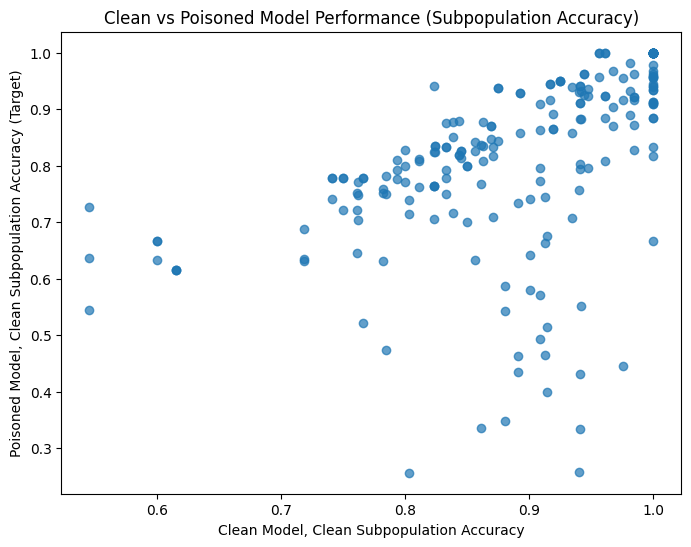

In [67]:
plt.figure(figsize=(8,6))
plt.scatter(fm_df['Clean Model, Clean Subpopulation accuracy (subpop baseline)'], 
            fm_df['Poisoned Model, Clean Subpopulation accuracy (target)'], alpha=0.7)
plt.title("Clean vs Poisoned Model Performance (Subpopulation Accuracy)")
plt.xlabel("Clean Model, Clean Subpopulation Accuracy")
plt.ylabel("Poisoned Model, Clean Subpopulation Accuracy (Target)")
plt.show()

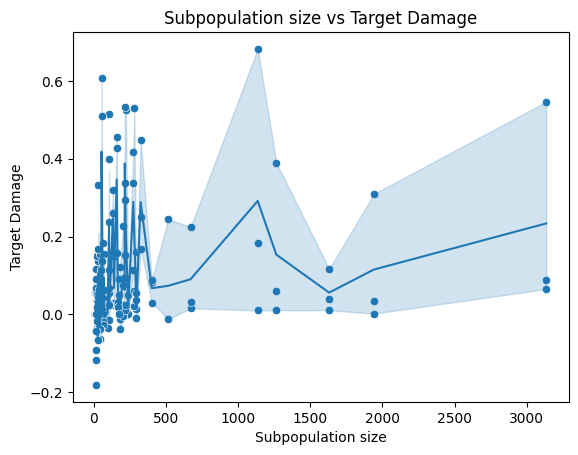

In [ ]:
sns.scatterplot(x='Subpopulation size', y='Target Damage', data=fm_df)
sns.lineplot(x='Subpopulation size', y='Target Damage', data=fm_df)
plt.title("Subpopulation size vs Target Damage")
plt.xlabel("Subpopulation size")
plt.ylabel("Target Damage")
plt.savefig('visuals/uci_fm_subpop_size_target_damage.pdf')
plt.show()

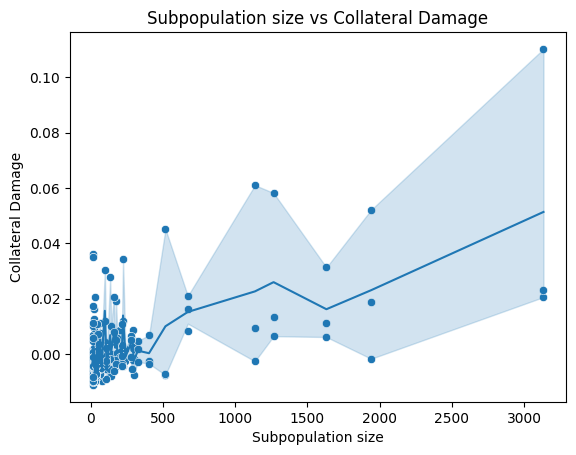

In [84]:
sns.scatterplot(x='Subpopulation size', y='Collateral Damage', data=fm_df)
sns.lineplot(x='Subpopulation size', y='Collateral Damage', data=fm_df)
plt.title("Subpopulation size vs Collateral Damage")
plt.xlabel("Subpopulation size")
plt.ylabel("Collateral Damage")
plt.savefig('visuals/uci_fm_subpop_size_collateral_damage.pdf')
plt.show()

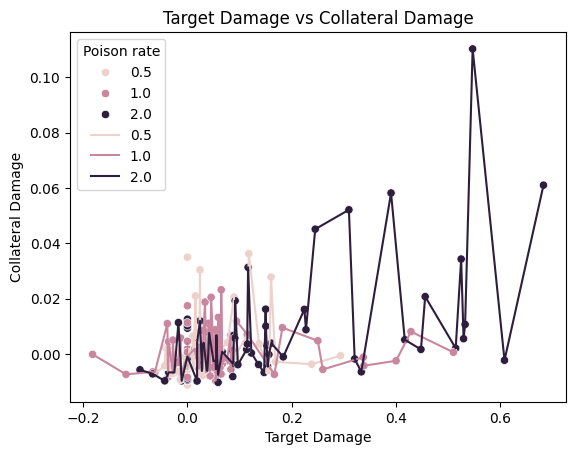

In [86]:
sns.scatterplot(x='Target Damage', y='Collateral Damage', data=fm_df, hue='Poison rate')
sns.lineplot(x='Target Damage', y='Collateral Damage', data=fm_df, hue='Poison rate')

plt.title("Target Damage vs Collateral Damage")
plt.xlabel("Target Damage")
plt.ylabel("Collateral Damage")
plt.savefig('visuals/uci_fm_target_collateral_damage.pdf')
plt.show()

In [70]:
km_df.head()

,Cluster index,Cluster count,Poison rate,Number of poisoned samples,Original dataset size,Poisoned dataset size,Clean Model Accuracy,"Poisoned Model, Clean Subpopulation accuracy (target)","Clean Model, Clean Subpopulation accuracy (subpop baseline)",Number of samples tested on poisoned model,"Poisoned Model, Clean Test Data accuracy (collateral)","Clean Model, Poison Data accuracy","Poisoned Model, Poison Data accuracy"
0,0,2341,0.5,1170,16280,17450,0.84485,0.873023,0.878153,2339,0.850931,0.880393,0.872277
1,0,2341,1.0,2341,16280,18621,0.84485,0.820436,0.878153,2339,0.830600,0.880393,0.810765
2,0,2341,2.0,4682,16280,20962,0.84485,0.736640,0.878153,2339,0.791966,0.880393,0.724477
3,1,81,0.5,40,16280,16320,0.84485,1.000000,1.000000,85,0.843744,1.000000,1.000000
4,1,81,1.0,81,16280,16361,0.84485,1.000000,1.000000,85,0.841472,1.000000,1.000000


In [ ]:
km_df["Target Damage"] = km_df['Clean Model, Clean Subpopulation accuracy (subpop baseline)'] - km_df['Poisoned Model, Clean Subpopulation accuracy (target)']
km_df["Collateral Damage"] = km_df['Clean Model Accuracy'] - km_df['Poisoned Model, Clean Test Data accuracy (collateral)']

km_df_analyse = km_df[(km_df['Target Damage'] != 1.0) & 
                        (km_df['Poisoned Model, Clean Subpopulation accuracy (target)'] > 0.1)]

km_pr_05 = km_df_analyse[km_df_analyse['Poison rate'] == 0.5]
km_pr_1 = km_df_analyse[km_df_analyse['Poison rate'] == 1]
km_pr_2 = km_df_analyse[km_df_analyse['Poison rate'] == 2]

pr05_highest1_target = km_pr_05.nlargest(1, 'Target Damage')
pr05_highest5_target = km_pr_05.nlargest(5, 'Target Damage')
pr05_highest10_target = km_pr_05.nlargest(10, 'Target Damage')

pr05_highest1_collateral = pr05_highest1_target['Collateral Damage']
pr05_highest5_collateral = pr05_highest5_target['Collateral Damage']
pr05_highest10_collateral = pr05_highest10_target['Collateral Damage']

print("POISONING RATE 0.5")

print(f"Highest individual target damage: {pr05_highest1_target['Target Damage'].mean() * 100}")
print(f"Highest 5 target damage: {pr05_highest5_target['Target Damage'].mean() * 100}")
print(f"Highest 10 target damage: {pr05_highest10_target['Target Damage'].mean() * 100}")

print(f"Highest individual collateral damage: {pr05_highest1_collateral.mean() * 100}")
print(f"Highest 5 collateral damage: {pr05_highest5_collateral.mean() * 100}")
print(f"Highest 10 collateral damage: {pr05_highest10_collateral.mean() * 100}")


pr1_highest1_target = km_pr_1.nlargest(1, 'Target Damage')
pr1_highest5_target = km_pr_1.nlargest(5, 'Target Damage')
pr1_highest10_target = km_pr_1.nlargest(10, 'Target Damage')

pr1_highest1_collateral = pr1_highest1_target['Collateral Damage']
pr1_highest5_collateral = pr1_highest5_target['Collateral Damage']
pr1_highest10_collateral = pr1_highest10_target['Collateral Damage']

print("POISONING RATE 1")

print(f"Highest individual target damage: {pr1_highest1_target['Target Damage'].mean() * 100}")
print(f"Highest 5 target damage: {pr1_highest5_target['Target Damage'].mean() * 100}")
print(f"Highest 10 target damage: {pr1_highest10_target['Target Damage'].mean() * 100}")

print(f"Highest individual collateral damage: {pr1_highest1_collateral.mean() * 100}")
print(f"Highest 5 collateral damage: {pr1_highest5_collateral.mean() * 100}")
print(f"Highest 10 collateral damage: {pr1_highest10_collateral.mean() * 100}")


pr2_highest1_target = km_pr_2.nlargest(1, 'Target Damage')e
pr2_highest5_target = km_pr_2.nlargest(5, 'Target Damage')
pr2_highest10_target = km_pr_2.nlargest(10, 'Target Damage')

pr2_highest1_collateral = pr2_highest1_target['Collateral Damage']
pr2_highest5_collateral = pr2_highest5_target['Collateral Damage']
pr2_highest10_collateral = pr2_highest10_target['Collateral Damage']

print("POISONING RATE 2")

print(f"Highest individual target damage: {pr2_highest1_target['Target Damage'].mean() * 100}")
print(f"Highest 5 target damage: {pr2_highest5_target['Target Damage'].mean() * 100}")
print(f"Highest 10 target damage: {pr2_highest10_target['Target Damage'].mean() * 100}")

print(f"Highest individual collateral damage: {pr2_highest1_collateral.mean() * 100}")
print(f"Highest 5 collateral damage: {pr2_highest5_collateral.mean() * 100}")
print(f"Highest 10 collateral damage: {pr2_highest10_collateral.mean() * 100}")

POISONING RATE 0.5
Highest individual target damage: 80.0
Highest 5 target damage: 69.21428571428571
Highest 10 target damage: 49.12503021513174
Highest individual collateral damage: -0.3071064430931636
Highest 5 collateral damage: 0.10318776487931113
Highest 10 collateral damage: -0.21436029727903264
POISONING RATE 1
Highest individual target damage: 85.71428571428571
Highest 5 target damage: 60.21428571428572
Highest 10 target damage: 40.38196103413495
Highest individual collateral damage: -0.6449235304956669
Highest 5 collateral damage: -0.38695411829739124
Highest 10 collateral damage: 0.16890854370125274
POISONING RATE 2
Highest individual target damage: 69.56521739130434
Highest 5 target damage: 55.571626910795246
Highest 10 target damage: 43.08606749605515
Highest individual collateral damage: 4.858423929734046
Highest 5 collateral damage: 2.8290645537743386
Highest 10 collateral damage: 2.2492475892144226


In [72]:
# print(km_df.to_string())

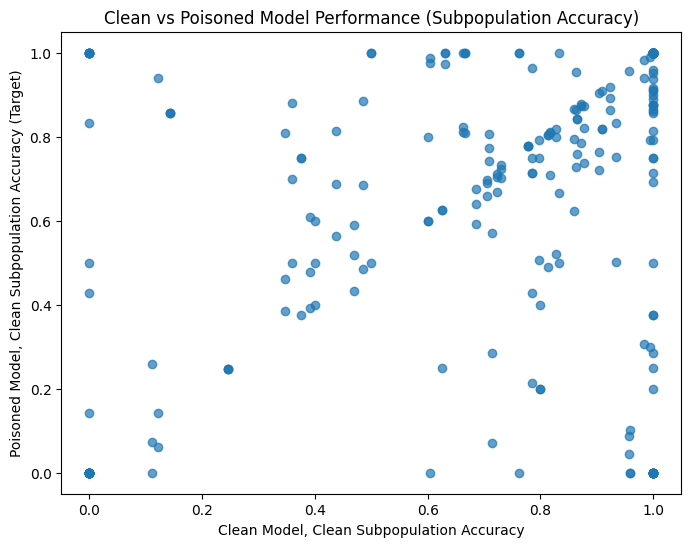

In [73]:
plt.figure(figsize=(8,6))
plt.scatter(km_df['Clean Model, Clean Subpopulation accuracy (subpop baseline)'], 
            km_df['Poisoned Model, Clean Subpopulation accuracy (target)'], alpha=0.7)
plt.title("Clean vs Poisoned Model Performance (Subpopulation Accuracy)")
plt.xlabel("Clean Model, Clean Subpopulation Accuracy")
plt.ylabel("Poisoned Model, Clean Subpopulation Accuracy (Target)")
plt.show()

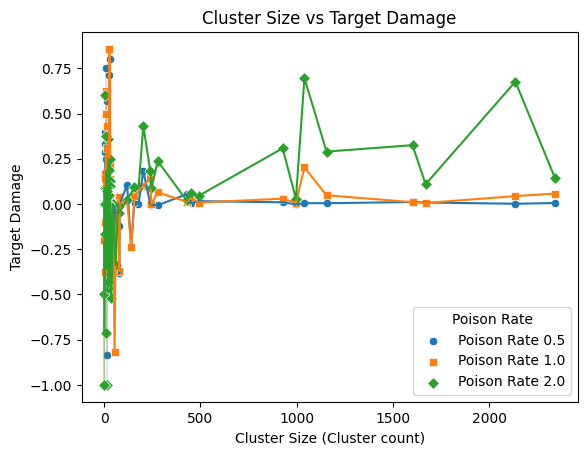

In [78]:
plt.figsize=(16,6)

sns.scatterplot(x='Cluster count', y='Target Damage', data=km_pr_05, label='Poison Rate 0.5', marker='o')
sns.lineplot(x='Cluster count', y='Target Damage', data=km_pr_05)

sns.scatterplot(x='Cluster count', y='Target Damage', data=km_pr_1, label='Poison Rate 1.0', marker='s')
sns.lineplot(x='Cluster count', y='Target Damage', data=km_pr_1)

sns.scatterplot(x='Cluster count', y='Target Damage', data=km_pr_2, label='Poison Rate 2.0', marker='D')
sns.lineplot(x='Cluster count', y='Target Damage', data=km_pr_2)

# Add labels and legend
plt.title("Cluster Size vs Target Damage")
plt.xlabel("Cluster Size (Cluster count)")
plt.ylabel("Target Damage")
plt.legend(title='Poison Rate')  # Add a legend title
plt.show()

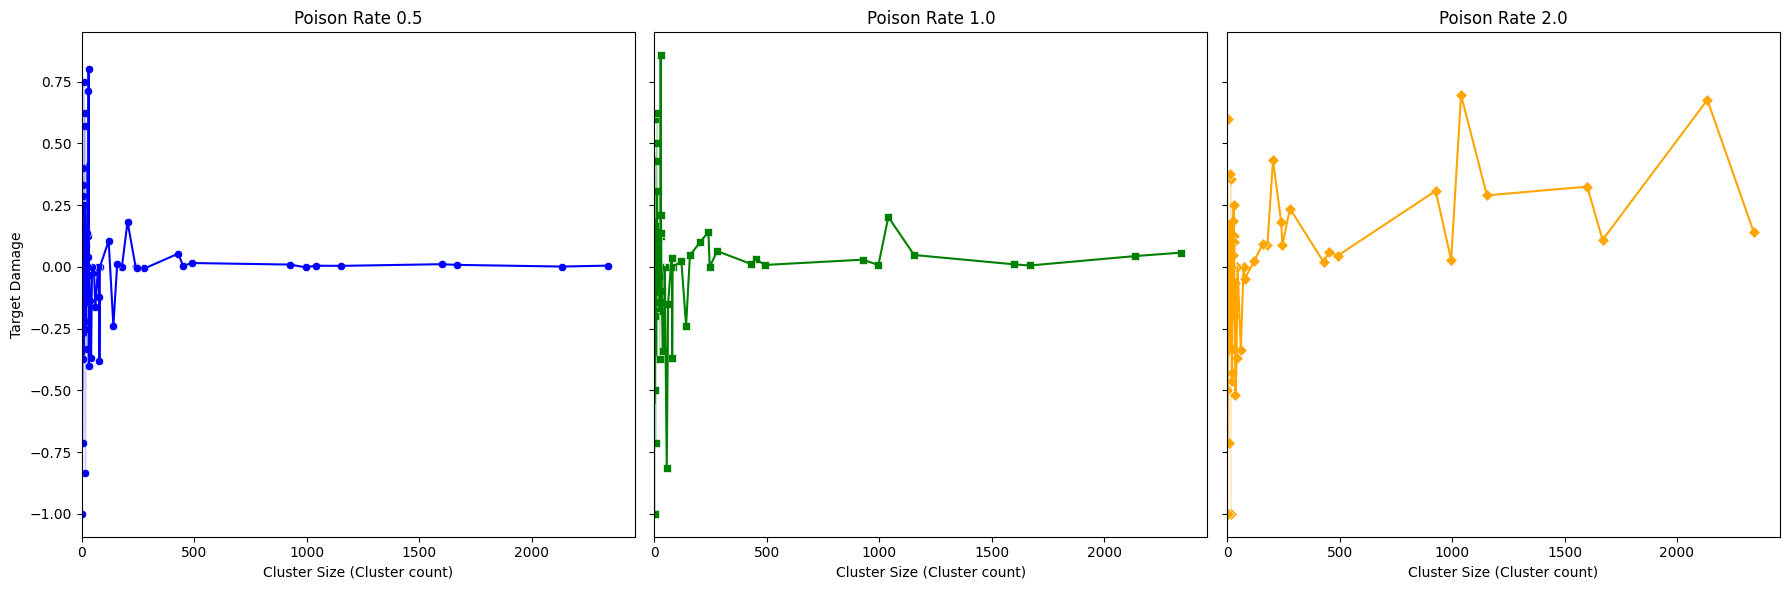

In [82]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # Share y-axis for easier comparison

# Define the datasets and labels
datasets = [(km_pr_05, "Poison Rate 0.5", 'blue'), (km_pr_1, "Poison Rate 1.0", 'green'), (km_pr_2, "Poison Rate 2.0", 'orange')]
markers = ['o', 's', 'D']  # Different markers for each

# Loop through subplots
for ax, (data, title, colour), marker in zip(axes, datasets, markers):
    sns.scatterplot(x='Cluster count', y='Target Damage', data=data, ax=ax, marker=marker, color=colour)
    sns.lineplot(x='Cluster count', y='Target Damage', data=data, ax=ax, color=colour)
    
    ax.set_title(title)  # Set subplot title
    ax.set_xlabel("Cluster Size (Cluster count)")
    ax.set_xlim(left=0)  # Ensure no extra space on the left

# Global y-label
axes[0].set_ylabel("Target Damage")  

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

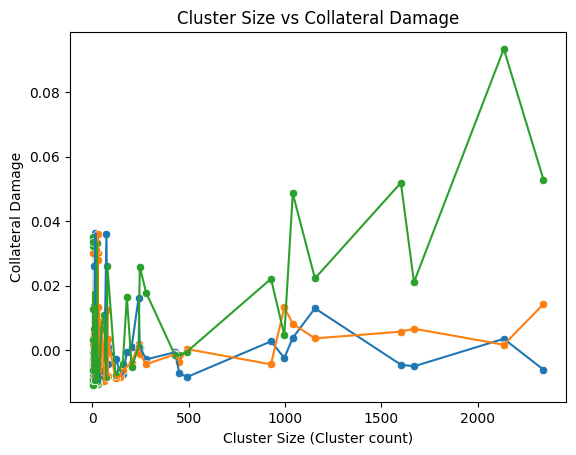

In [75]:
sns.scatterplot(x='Cluster count', y='Collateral Damage', data=km_pr_05)
sns.lineplot(x='Cluster count', y='Collateral Damage', data=km_pr_05)
sns.scatterplot(x='Cluster count', y='Collateral Damage', data=km_pr_1)
sns.lineplot(x='Cluster count', y='Collateral Damage', data=km_pr_1)
sns.scatterplot(x='Cluster count', y='Collateral Damage', data=km_pr_2)
sns.lineplot(x='Cluster count', y='Collateral Damage', data=km_pr_2)
plt.title("Cluster Size vs Collateral Damage")
plt.xlabel("Cluster Size (Cluster count)")
plt.ylabel("Collateral Damage")
plt.show()

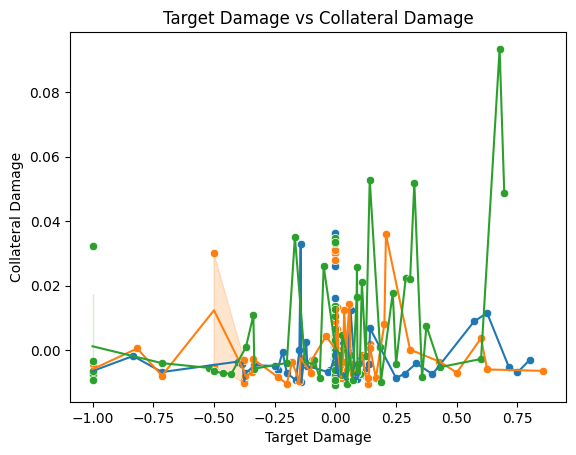

In [87]:
sns.scatterplot(x='Target Damage', y='Collateral Damage', data=km_pr_05)
sns.lineplot(x='Target Damage', y='Collateral Damage', data=km_pr_05)
sns.scatterplot(x='Target Damage', y='Collateral Damage', data=km_pr_1)
sns.lineplot(x='Target Damage', y='Collateral Damage', data=km_pr_1)
sns.scatterplot(x='Target Damage', y='Collateral Damage', data=km_pr_2)
sns.lineplot(x='Target Damage', y='Collateral Damage', data=km_pr_2)
plt.title("Target Damage vs Collateral Damage")
plt.xlabel("Target Damage")
plt.ylabel("Collateral Damage")
plt.savefig('visuals/uci_km_target_collateral_damage.pdf')
plt.show()